In [1]:
push!(LOAD_PATH, joinpath(@__DIR__, "..", "src"))

4-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"
 "/net/fs09/d0/jpalmo/Projects/O3Fire/paper/code/boxmodel/figures/../src"

In [2]:
using RateLaws

In [3]:
using BoxModel

In [4]:
using CSV
using DataFrames
using Statistics
using Dates
using DifferentialEquations
using ModelingToolkit
using CairoMakie
using LaTeXStrings

In [5]:
# replace this with shipped model-obs data
# df = DataFrame(CSV.File("/home/jpalmo/fs09/Projects/O3Fire/model_eval/output/model_obs_2024.7.31.csv", dateformat="yyyy-mm-dd"));
df = DataFrame(CSV.File("/home/jpalmo/fs09/Projects/O3Fire/model_eval/output/model_obs_2025.4.16.csv", dateformat="yyyy-mm-dd"));

In [6]:
fire_df = df[df.regime .== "fire", :];
mixed_df = df[df.regime .== "heavy_mixed", :];

In [7]:
### derive ASA from mass concentration assuming a constant 
### specific surface area of 4 m2 g−1 (following Lindsay et al 2022)
fire_df.ASA = fire_df.OA_AMS .* 4;

# scale gas concentrations by CO
fire_df.NOxCO = fire_df.NOx ./ fire_df.CO;
fire_df.CH2OCO = fire_df.CH2O ./ fire_df.CO;
fire_df.HNO2CO = fire_df.HNO2 ./ fire_df.CO;

In [8]:
# Filter out rows with missing values
fire_df = dropmissing(fire_df, :age);
fire_df = dropmissing(fire_df, :NOx);
fire_df = dropmissing(fire_df, :CO);

mixed_df = dropmissing(mixed_df, :NOx);
mixed_df = dropmissing(mixed_df, :age);

mixed_df = mixed_df[mixed_df.NOx .> 0, :];
fire_df = fire_df[fire_df.NOx .> 0, :];

# Apply the condition on the filtered DataFrame
near_field = fire_df[fire_df.age .< 20, :];
far_field = fire_df[fire_df.age .> 20, :];

In [9]:
# drop Infs and NaNs
near_field = near_field[.!isnan.(near_field.NOx), :];
far_field = far_field[.!isnan.(far_field.NOx), :];
near_field = near_field[.!isnan.(near_field.CO), :];
far_field = far_field[.!isnan.(far_field.CO), :];

# Build Isopleth

In [10]:
n=20;
tspan = (0, 24*60*60);

In [11]:
initial_NO = range(1e-3, stop = 50, length = n)' .* ones(n)
initial_RH = range(1, stop = 800, length = n)' .* ones(n);
initial_NO_log = (10 .^ range(-2.5, stop=1.6, length=n))' .* ones(n)
initial_RH_log = (10 .^ range(0.5, stop=3, length=n))' .* ones(n);

In [12]:
initial_NO = initial_NO'
initial_NO2 = initial_NO ./ 2;
initial_NO_log = initial_NO_log'
initial_NO2_log = initial_NO_log ./ 2;

In [13]:
oprob = ODEProblem(rxn_sys, [], tspan, [], combinatoric_ratelaws=false);
sprob = SteadyStateProblem(oprob);
simprobs = []
simprobs_log = []
function prob_func(prob, i, repeat)
    u_tmp = [:NO => initial_NO[i], :RH => initial_RH[i], :CO => initial_RH[i]*(1/0.127), :CH2O => initial_RH[i]*(1/0.127)*(0.01792), :HNO2 => initial_RH[i]*(1/0.127)*(0.00189), :I => 1]
    # u_tmp = [:NO => initial_NO[i], :RH => initial_RH[i], :CO => 100, :CH2O => 3, :HNO2 => 0, :I => 1]
    oprob = ODEProblem(rxn_sys, u_tmp, tspan, [:ASA=>0], combinatoric_ratelaws=false);
    push!(simprobs, SteadyStateProblem(oprob))
    SteadyStateProblem(oprob);
end;
function prob_func_log(prob, i, repeat)
    u_tmp = [:NO => initial_NO_log[i], :RH => initial_RH_log[i], :CO => initial_RH_log[i]*(1/0.127), :CH2O => initial_RH_log[i]*(1/0.127)*(0.01792), :HNO2 => initial_RH_log[i]*(1/0.127)*(0.00189), :I => 1]
    oprob = ODEProblem(rxn_sys, u_tmp, tspan, [], combinatoric_ratelaws=false);
    push!(simprobs_log, SteadyStateProblem(oprob))
    SteadyStateProblem(oprob);
end;

In [14]:
ensemble_prob = EnsembleProblem(sprob, prob_func = prob_func);
ensemble_prob_log = EnsembleProblem(sprob, prob_func = prob_func_log);

In [15]:
sim = solve(ensemble_prob, DynamicSS(Rosenbrock23()), EnsembleThreads(), trajectories = n*n);

In [16]:
log_sim = solve(ensemble_prob_log, DynamicSS(Rosenbrock23()), EnsembleThreads(), trajectories = n*n);

In [17]:
kHO2NO = GCARR_ac(3.30e-12, 270.0e0)*2.46e10;
kNORO2 = GC_RO2NO_B2_aca(2.90e-12, 350.0e0, 3.0e0)*2.46e10;

In [18]:
o3ss = zeros(Float64, n*n)
for (i,s) in enumerate(sim)
    # o3ss[i] = maximum(sim[i][2])#.+sim[i][6])
    tmp_prob = simprobs[i]
    o3ss[i] = kHO2NO.*s[:HO2].*(ModelingToolkit.getp(tmp_prob, :NO)(tmp_prob)) + kNORO2.*s[:RO2].*(ModelingToolkit.getp(tmp_prob, :NO)(tmp_prob)).*(1 - (ModelingToolkit.getp(tmp_prob, :α)(tmp_prob)))*3600
    # o3ss[i] = (s[O3] ./ (ModelingToolkit.getp(tmp_prob, CO)(tmp_prob)))
end
log_o3ss = zeros(Float64, n*n)
for (i,s) in enumerate(log_sim)
    tmp_prob = simprobs_log[i]
    log_o3ss[i] = kHO2NO.*s[:HO2].*(ModelingToolkit.getp(tmp_prob, :NO)(tmp_prob)) + kNORO2.*s[:RO2].*(ModelingToolkit.getp(tmp_prob, :NO)(tmp_prob)).*(1 - (ModelingToolkit.getp(tmp_prob, :α)(tmp_prob)))*3600
    # log_o3ss[i] = maximum(log_sim[i][2])
end

# Observations

In [19]:
using LinearAlgebra
using Distributions

In [20]:
function getellipsepoints(cx, cy, rx, ry, θ)
	t = range(0, 2*pi, length=100)
	ellipse_x_r = @. rx * cos(t)
	ellipse_y_r = @. ry * sin(t)
	R = [cos(θ) sin(θ); -sin(θ) cos(θ)]
	r_ellipse = [ellipse_x_r ellipse_y_r] * R
	x = @. cx + r_ellipse[:,1]
	y = @. cy + r_ellipse[:,2]
	(x,y)
end

function getellipsepoints(μ, Σ, confidence=0.95)
	quant = quantile(Chisq(2), confidence) |> sqrt
	cx = μ[1]
	cy =  μ[2]
	
	egvs = eigvals(Σ)
	if egvs[1] > egvs[2]
		idxmax = 1
		largestegv = egvs[1]
		smallesttegv = egvs[2]
	else
		idxmax = 2
		largestegv = egvs[2]
		smallesttegv = egvs[1]
	end

	rx = quant*sqrt(largestegv)
	ry = quant*sqrt(smallesttegv)
	
	eigvecmax = eigvecs(Σ)[:,idxmax]
	θ = atan(eigvecmax[2]/eigvecmax[1])
 	if θ < 0
		θ += 2*π
	end

	getellipsepoints(cx, cy, rx, ry, θ)
end

getellipsepoints (generic function with 3 methods)

In [21]:
near_field_data = near_field[:, [:CO, :NOx,]]./1e3;
near_field_data.CO = near_field_data.CO .* 0.127;
near_field_data = log10.(near_field_data)
far_field_data = far_field[:, [:CO, :NOx,]]./1e3;
far_field_data.CO = far_field_data.CO .* 0.127;
far_field_data = log10.(far_field_data);

## Get Ellipse Points

In [22]:
near_field_μ = [quantile(near_field_data[:,1], 0.75), quantile(near_field_data[:,2], 0.75)]
near_field_Σ = cov(Matrix(near_field_data))

far_field_μ = [quantile(far_field_data[:,1], 0.75), quantile(far_field_data[:,2], 0.75)]
far_field_Σ = cov(Matrix(far_field_data))

2×2 Matrix{Float64}:
 0.0259617  0.036209
 0.036209   0.300728

In [23]:
toe_μ = [(134.24*4), (5.37*4)]
toe_std = [(18.23*4), (4.92*4)]
rho = 0

cov_matrix = [toe_std[1]^2    rho * toe_std[1] * toe_std[2];
                  rho * toe_std[1] * toe_std[2]    toe_std[2]^2]

# Eigen decomposition of the log-transformed covariance matrix
eigenvalues, eigenvectors = eigen(cov_matrix)

# Lengths of the ellipse axes in log space
axis_lengths = sqrt.(eigenvalues)

# Generate points on a unit circle
angles = LinRange(0, 2π, 100)
circle = [(cos(a), sin(a)) for a in angles]

# Transform the unit circle to match the ellipse
ellipse = [
    (toe_μ[1], toe_μ[2]) .+ eigenvectors * (axis_lengths .* point) for point in circle
]

# Extract x and y coordinates from ellipse points
ellipse_x = [point[1] for point in ellipse]
ellipse_y = [point[2] for point in ellipse]

toe_x = ellipse_x
toe_y = ellipse_y;

In [24]:
near_field_data = 10 .^ near_field_data
far_field_data = 10 .^ far_field_data

near_field_ellipse = getellipsepoints(near_field_μ, near_field_Σ);
near_field_ellipse_x = 10 .^ near_field_ellipse[1]
near_field_ellipse_y = 10 .^ near_field_ellipse[2]

far_field_ellipse = getellipsepoints(far_field_μ, far_field_Σ);
far_field_ellipse_x = 10 .^ far_field_ellipse[1]
far_field_ellipse_y = 10 .^ far_field_ellipse[2];

# Plot

## Figure 7a

In [25]:
using Printf

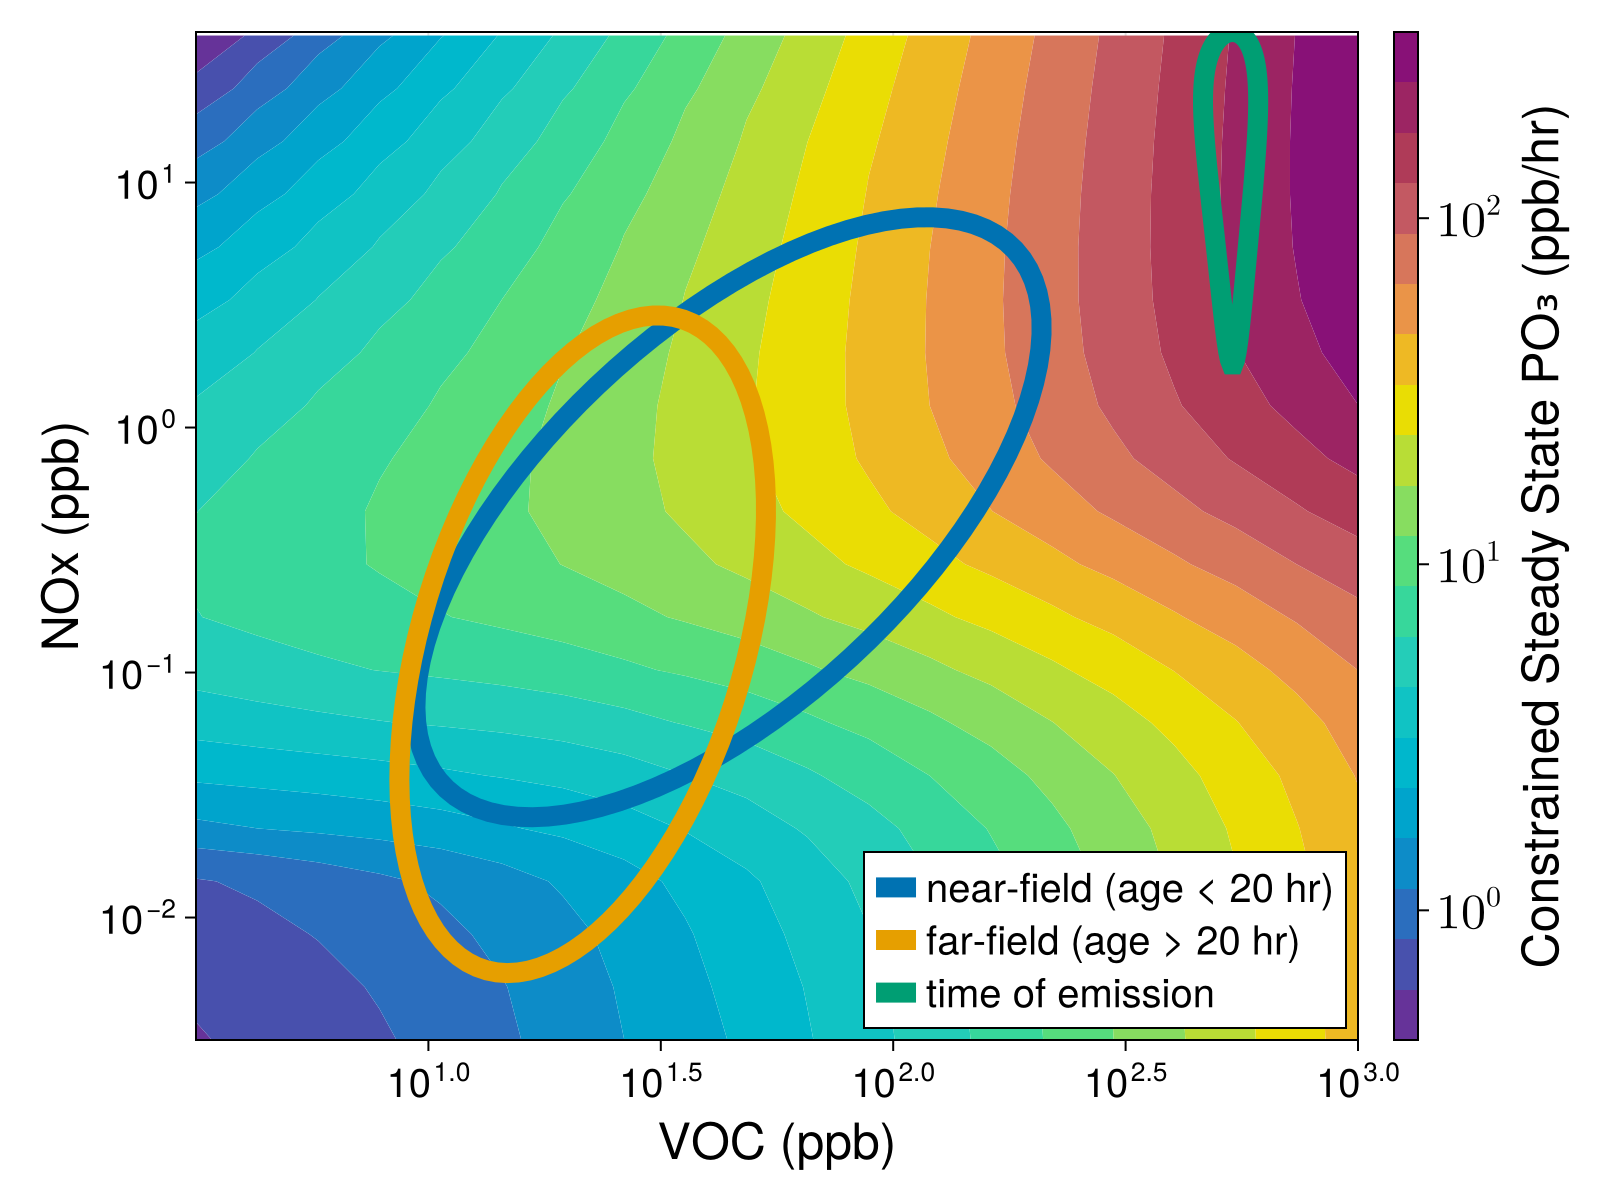

In [54]:
f = Figure(size = (800, 600))
ax = Axis(f[1, 1], xlabel = "VOC (ppb)", ylabel = "NOx (ppb)", xscale = log10, yscale = log10,)
ax.xlabelsize=25
ax.ylabelsize=25
ax.xticklabelsize=20
ax.yticklabelsize=20
co = CairoMakie.contourf!(initial_RH_log[1,:], (initial_NO_log[:,1]), reshape(log10.(log_o3ss), (n,n))', colormap=cgrad(:twelvebitrainbow, rev = true,), levels=20)# colorrange = (20, 150))
CairoMakie.lines!(near_field_ellipse_x, near_field_ellipse_y, label="near-field (age < 20 hr)", linewidth=10)
CairoMakie.lines!(far_field_ellipse_x, far_field_ellipse_y, label="far-field (age > 20 hr)", linewidth=10)
# CairoMakie.lines!(getellipsepoints(toe_μ[1], toe_μ[2], toe_Σ[1], toe_Σ[2], 0)..., label="time of emission")
# CairoMakie.lines!(toe_ellipse_x, toe_ellipse_y, label="time of emission", linewidth=10)
CairoMakie.lines!(toe_x, toe_y, label="time of emission", linewidth=10)
tightlimits!(ax)
# CairoMakie.xlims!(ax, 50, 1000)
# CairoMakie.ylims!(ax, 0.1, 40)

# Choose tick positions manually in log space
tickvals = [0.0, 1.0, 2.0]  # log10(1), log10(10), log10(100)

# LaTeX-style labels
ticklabels = [L"10^0", L"10^1", L"10^2"]

Colorbar(f[1, 2], co,
    label = "Constrained Steady State PO₃ (ppb/hr)",
    labelsize = 25,
    ticklabelsize = 25,
    ticks = (tickvals, ticklabels)
);

# Colorbar(f[1, 2], co, label="Constrained Steady State PO₃ (ppb/hr)", labelsize=25, ticklabelsize=20);
axislegend(ax, position = :rb, labelsize=20)
# Add bold "a)" in top-left corner
# text!(ax.scene, "a)", position = Point2f(3.5, 40),
#       align = (:left, :top), fontsize=30, font=:bold)
# save figure as PNG, high quality
CairoMakie.save("../../../figures/fig_07a.png", f,)
f